In [1]:
# use as template for scope data, etc
# specific functions for analyzing two-trace plots from the beatnote spectrum analyzer

In [12]:
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel
from numpy import *
import csv
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [113]:
def process_csv(filename, exclude=2, hd=False):
    exampleFile = open(filename, encoding='utf-8')
    exampleReader = csv.reader(exampleFile)
    exampleData = list(exampleReader)
    if hd is not False:
        print(exampleData[1])
    exampleFile.close()
    return exampleData[exclude:]

def get_region_df(df, xcol, offset, halfwidth, noffset=False):
    """ df is a two-column dataframe. return subset of rows zoomed in
        on the region within [offset-halfwidth, offset+halfwidth]. 
    """
    sub_df = df[(df[xcol]>offset-halfwidth) & (df[xcol]<offset+halfwidth)]
    if noffset is True:
        sub_df[xcol] -= offset
    return sub_df

def get_traces(df):
    
    # make this a loop 
    trace1_df = df[[0,2]].astype(float)
    trace2_df = df[[4,6]].astype(float)
    
    trace_pts1 = trace1_df.values.transpose()
    trace_pts2 = trace2_df.values.transpose()
    
    return trace_pts1, trace_pts2

def lorentz(x,gamma,x0):
    return .5*gamma/(pi*(x-x0)**2 + (.5*gamma)**2)

def undB(dB):
    return 10**(dB/10)
    
def get_fw3dB(sigma):
    """Full width at -3dB. sigma is the same as gamma"""
    return sqrt(10**(3/10)-1)*2*sigma

In [4]:
data = process_csv("81.9mA 960.csv")

['Freq', '', 'Amp', '', 'Freq', '', 'Amp', '', '']


In [41]:
df = DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8
0,64602485,Hz,-94.33,dBm,64602485,Hz,-93.93,dBm,
1,64617262,Hz,-93.65,dBm,64617262,Hz,-94.25,dBm,
2,64632039,Hz,-94.20,dBm,64632039,Hz,-93.90,dBm,
3,64646816,Hz,-93.89,dBm,64646816,Hz,-93.98,dBm,
4,64661593,Hz,-94.26,dBm,64661593,Hz,-94.20,dBm,


In [64]:
tr1,tr2 = get_traces(df)
x1,y1 = tr1
x2,y2 = tr2

In [99]:
# Lorentzian fit with lmfit package

y1 = [undB(y) for y in y1]

model = LorentzianModel() 
params = model.guess(y1,x=x1)
out = model.fit(y1,params,x=x1)
fwhm = params["fwhm"].value

params

name,value,initial value,min,max,vary,expression
amplitude,6.14759287,None,-inf,inf,True,
center,68939182.7,None,-inf,inf,True,
sigma,635411.000,None,0.00000000,inf,True,
fwhm,1270822.00,None,-inf,inf,False,2.0000000*sigma
height,3.0796e-06,None,-inf,inf,False,"0.3183099*amplitude/max(2.220446049250313e-16, sigma)"


In [117]:
# FWHM for each file
files = ["35mA 960.csv","40mA 960.csv","50mA 960.csv","60mA 960.csv",
         "70.9mA 960.csv","81.9mA 960.csv"]

fwhm_list = []
fw3dB_list = []
frames = {} # store the points in each plot

I = [35,40,50,60,70.9,81.9]

for current,file in zip(I,files):
    
    # extract the traces; might be log(y) plots!
    tr1, tr2 = get_traces(DataFrame(process_csv(file)))
    x2,y2 = tr2
    x1,y1 = tr1
    
    # store the frame
    frames[current]= [[x1,y1],[x2, y2]]
    
    y2 = [undB(y) for y in y2]
    y1 = [undB(y) for y in y1]
    
    # Lorenztian fit with lmfit package; fit only one trace
    model = LorentzianModel() 
    params = model.guess(y2,x=x2)
    out = model.fit(y2,params,x=x2)
    fwhm_list.append(params["fwhm"].value)
    fw3dB_list.append(get_fw3dB(params["sigma"].value))
    
fwhm = array(fwhm_list)/1e6 
fw3dB = array(fw3dB_list)/1e6

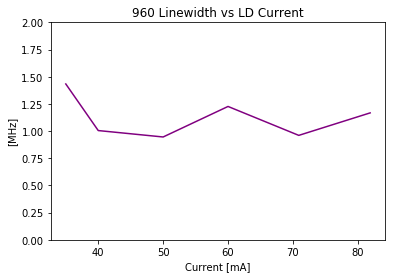

In [115]:
fig,ax = plt.subplots()
ax.set_title("960 Linewidth vs LD Current")
ax.set_xlabel("Current [mA]")
ax.set_ylabel("[MHz]")
ax.set_ylim((0,2))
ax.plot(I,fwhm,c="purple") 
plt.show()

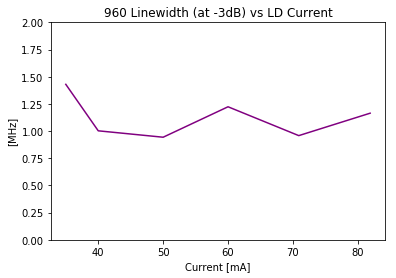

In [118]:
fig,ax = plt.subplots()
ax.set_title("960 Linewidth (at -3dB) vs LD Current")
ax.set_xlabel("Current [mA]")
ax.set_ylabel("[MHz]")
ax.set_ylim((0,2))
ax.plot(I,fw3dB,c="purple") 
plt.show()

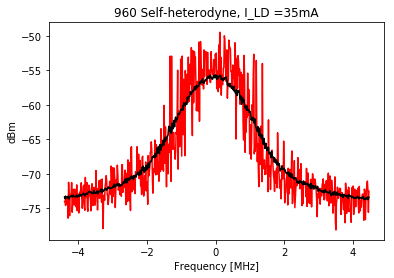

In [88]:
i = 35 # the current
x,y = frames[i][0]
xavg,yavg = frames[i][1]

fig,ax = plt.subplots()
ax.set_title(f"960 Self-heterodyne, I_LD ={i}mA")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("dBm")
# ax.set_ylim((0,2))
ax.plot(array([x-6.9e7 for x in x])/1e6,y,c="red")
ax.plot(array([x-6.9e7 for x in xavg ])/1e6,yavg,c="k")
plt.show()

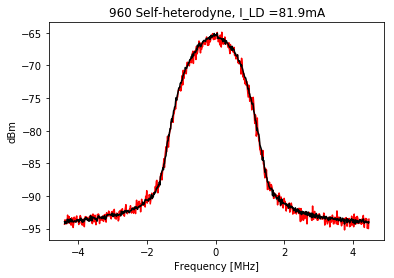

In [89]:
i = 81.9 # the current
x,y = frames[i][0]
xavg,yavg = frames[i][1]

fig,ax = plt.subplots()
ax.set_title(f"960 Self-heterodyne, I_LD ={i}mA")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("dBm")
# ax.set_ylim((0,2))
ax.plot(array([x-6.9e7 for x in x])/1e6,y,c="red")
ax.plot(array([x-6.9e7 for x in xavg ])/1e6,yavg,c="k")
plt.show()

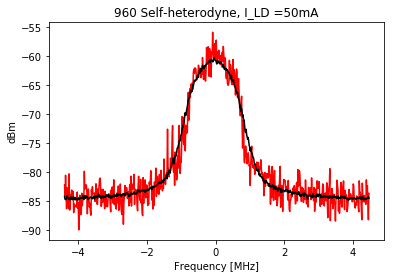

In [90]:
i = 50 # the current
x,y = frames[i][0]
xavg,yavg = frames[i][1]

fig,ax = plt.subplots()
ax.set_title(f"960 Self-heterodyne, I_LD ={i}mA")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("dBm")
# ax.set_ylim((0,2))
ax.plot(array([x-6.9e7 for x in x])/1e6,y,c="red")
ax.plot(array([x-6.9e7 for x in xavg ])/1e6,yavg,c="k")
plt.show()

In [94]:
# stated spectral width of QPHOTONICS 960 nm diode from wiki:
c = 3e8
dl = .43e-9
l = 960e-9
dnu = c*dl/(l**2)
dnu/1e9

139.97395833333337